## Summary of observations

1) **INITIAL COMPARISON**, 10 EPOCHS, BS = 256, Numb. Training Samples=10000, lr = 0.0001:
- In terms of the **error plot**, the train error for joins performs excellently rising far quicker and seems to be converging higher than the test error for the non-joint. However the test error is a different story, after initially rising fast the joint test error plateuas off and even starts to decrease while the non-joint continues to rise fairly smoothly and overtake it. This implies that despite architecturally the joint and non-joint networks being the same, the joint training biases the learning towards **overfitting** the training set. This is interesting, some possible ideas:
    - overfitting is often considered as being a result of having to a model that is too complex, what happens if we reduce the number of parameters in the joint relative to the non-joint model?
    - why is the joint overfitting in the first place and not the joint? Another reason might be that the effective number of data points is less in some sense because of the way in which the joint trains each node on the average across all examples of a class, so perhaps it needs more data? This is contrary to our other experiments however and also does not make sense given the excellent training error
    - if we add a standard regulariser to the joint model does this improve things?
    
- In terms of **plotting the filters learned**, both models seem to have not trained the filters massively, with the reproductions being predominantly just black. This cannot entirely be the case however since the test error is around 60% and training error over 80% for the non-joint. So clearly something is being learned, suspect a problem with how the images are being generated. Indeed, if one multiplies the pixel values the numbers and filters learnt come more into focus, it seems that the filter weights learnt by the joint are much smaller in magnitude than the non-joint which is odd.

- The **histogram counts** are in both cases 0, this must be due to the fact that none of the outputs are greater than 1e-4. After actually inspecting the output of gamma3 this dosn't make sense, there are plenty of values which are greater than 1e-4 so this should be registering. Suspect error with how it is being computed. The **correlation plots** are therefore also messed up. After review is a problem with histogram threshold level, this has now been fixed and seems to be operating normally.

- Finally in terms of **robustness** the joint model consistently underperforms the non-joint, this is interesting as their test error is pretty much the same by the last epoch even if the non-joint is on a downward trajectory and the joint is on an upward.

2) **SECOND TEST**
After the first test the ket questions identified are as follows:
- Why is overfitting happening?
- Why are the filters being learned of such small weights?

To test the **overfitting** aspect we observe and look at the following:
- **what happens if we reduce the number of parameters in the model?**
    - to test this tried running the models again with same settings as before but decreased m3 from 512 to 256 and then 128. This sees a definite improvement for the joint model - although still not as good in terms of test error compared with the non-joint (and obviously still overfitting to some degree since the train error is still very good) the joint model's test error improved when it had m3=256 and 128 (they were about the same) vs when m3=512.
- **what happens if we increase the number of training data points?**
    - to test this tried running the models on 20,000 data points (double previous test) and keeping everything else the same. Weirdly while the non-joint predictably improved both on test and train given more training samples, the joint version, although once again learning far faster initially and its test error improving with the extra data, the test error actually was worse. This is very counter to usual machine learning where more data typically helps with generalisation. Interestingly the train error really is quite good, 5-10% better than the non-joint NN. Also interesting is that the histogram plot shows that the activations on test data are less consistent for members of the same class for the joint vs. the non-joint. Additionally there appear to be less activations implying the templates learnt by the jointare a less good match or that the biases are wrong. Assume this is also due to overfitting? 
- **what happens if we add some form of regularisation?**

To test and understand **why the filters being learned are so small in terms of magnitude** we look at the following:
- is it just that the weights themselves are small in the joint case, if so what happens when we increase the initilisation parameter or increase the learning rate?



In [57]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import time
import progressbar
import importlib
import random
# torch.manual_seed(1)    # reproducible
plt.style.use('default')
%matplotlib inline

import pdb


import Models_M_v2 as mds
import auxillary_functions as aux

# Hyper Parameters
EPOCH = 20

BATCH_SIZE = 256
DOWNLOAD = False

m1 = 64
m2 = 128
m3 = 128
ch_in = 3

cudaopt = True
EPS = 1e-6
histogram_level = int(np.ceil(0.8*EPOCH))

train_data = torchvision.datasets.SVHN(
    root='./data',
    
    split = 'train',
    transform = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ]),
    download=True,                        # download it if you don't have it
)
# LIMITING TRAINING DATA
Ntrain = int(10e3)
train_set = np.random.permutation(60000)[0:Ntrain]
train_data.data = train_data.data[torch.LongTensor(train_set),:,:]
train_data.labels = train_data.labels[torch.LongTensor(train_set)]

test_data = torchvision.datasets.SVHN(
    root='./data',
    split = 'test',                                     # this is testing data
    transform=torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
#                     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ]),
    download=True,                        # download it if you don't have it
)

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


## Visualise filters

<Figure size 432x288 with 0 Axes>

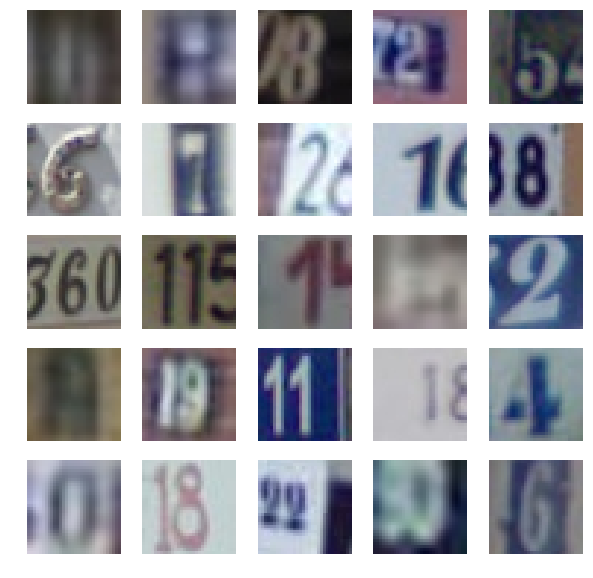

In [46]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

rows = 5
cols = 5
indices = random.sample(range(BATCH_SIZE), cols*rows)

idx = 1

plt.figure(1)
plt.figure(figsize=(10,10))
for j in range(rows):
    for i in range(cols):
        plt.subplot(rows,cols,idx)
        image = np.swapaxes(images.cpu().data.numpy()[idx-1], 0, 2)
        image = np.swapaxes(image, 0, 1)
        plt.imshow(image)
        plt.axis('off')
        idx+=1
plt.show()


### Train baseline neural network model

In [58]:
importlib.reload(mds)
importlib.reload(aux)

Loss_test_0 = np.zeros((EPOCH,))
Acc_test_0 = np.zeros((EPOCH,))
Acc_train_0 = np.zeros((EPOCH,))

print('\n\t\t\t\t\tTraining Joint NN \n')

activations_count3_0 = np.zeros((10, m3))

model_0 = mds.ML_NN(m1,m2,m3,ch_in)

if cudaopt:
    model_0.cuda()

optimizer = torch.optim.Adam(model_0.parameters(), lr = 0.0001, eps = EPS)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):
    bar.update((epoch+1)/EPOCH*100)
    model_0.train()
    
    train_correct = 0
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        encoded, scores,_,_,_ = model_0(b_x)
        
        train_pred = scores.data.max(1, keepdim=True)[1]
        train_correct += train_pred.eq(b_y.data.view_as(train_pred)).long().cpu().sum()
        
        loss = F.nll_loss(scores, b_y)      # negative log likelyhood
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
    
    Acc_train_0[epoch] =  100 * float(train_correct) /float(len(train_loader.dataset))    
        
    # testing
    model_0.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        gamma, scores,_,_,gamma3 = model_0(b_x)
        if epoch >= histogram_level:
            activations_count3_0 += aux.compute_histogram(gamma3, m3, b_y)
        
        test_loss += F.nll_loss(scores, b_y, size_average=False).data[0]
        pred = scores.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    Loss_test_0[epoch] = test_loss
    Acc_test_0[epoch] =  100*float(correct)/float(len(test_loader.dataset))
    
# torch.save(model_nn.state_dict(), 'nn_model.pt')

/ |#                                                  | 0 Elapsed Time: 0:00:00


					Training Joint NN 



/anaconda/envs/mlvm/lib/python3.6/site-packages/ipykernel/__main__.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
| |                                        #        | 100 Elapsed Time: 0:02:01

### Train joint neural network model

In [59]:
importlib.reload(mds)
importlib.reload(aux)

Loss_test_jnn = np.zeros((EPOCH,))
Acc_test_jnn = np.zeros((EPOCH,))
Acc_train_jnn = np.zeros((EPOCH,))

print('\n\t\t\t\t\tTraining Joint NN \n')

activations_count3_jnn = np.zeros((10, m3))

model_jnn = mds.ML_JNN_ReLU(m1,m2,m3,ch_in)
if cudaopt:
    model_jnn.cuda()

optimizer = torch.optim.Adam(model_jnn.parameters(), lr = 0.0001, eps = EPS, weight_decay = 0)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):
#     print("Epoch: " + str(int(epoch)))
    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model_jnn.train()
    
    train_correct = 0
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        encoded, scores = model_jnn.forward_joint(b_x, b_y)
        
        train_pred = scores.data.max(1, keepdim=True)[1]
        train_correct += train_pred.eq(b_y.data.view_as(train_pred)).long().cpu().sum()
        
        loss = F.nll_loss(scores, b_y)      # negative log likelyhood
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
    
    Acc_train_jnn[epoch] =  100 * float(train_correct) /float(len(train_loader.dataset))    
        
    # testing
    model_jnn.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        gamma, scores,_,_,gamma3 = model_jnn.forward(b_x)
        
        if epoch >= histogram_level:
            activations_count3_jnn += aux.compute_histogram(gamma3, m3, b_y)
        
        test_loss += F.nll_loss(scores, b_y, size_average=False).data[0]
        pred = scores.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    Loss_test_jnn[epoch] = test_loss
    Acc_test_jnn[epoch] =  100*float(correct)/float(len(test_loader.dataset))
    
# torch.save(model_jnn.state_dict(), 'jnn_model.pt')

/ |#                                                  | 0 Elapsed Time: 0:00:00


					Training Joint NN 



/anaconda/envs/mlvm/lib/python3.6/site-packages/ipykernel/__main__.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
| |                   #                             | 100 Elapsed Time: 0:02:05

### Plot test and train accuracies

/anaconda/envs/mlvm/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


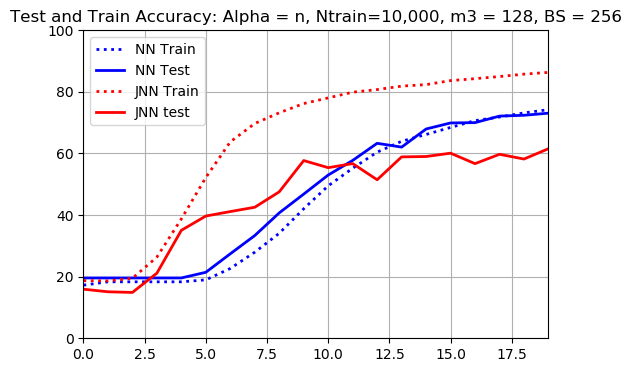

In [61]:
plt.style.use('default')
fig = plt.figure(figsize=(6,4))
plt.plot(Acc_train_0, ':b', linewidth = 2,label='NN Train')
plt.plot(Acc_test_0,'b',linewidth = 2,label='NN Test')
plt.plot(Acc_train_jnn,':r', linewidth = 2,label = 'JNN Train')
plt.plot(Acc_test_jnn,'r', linewidth = 2,label = 'JNN test')
plt.grid('on')
plt.title('Test and Train Accuracy: Alpha = n, Ntrain=10,000, m3 = 128, BS = 256')
plt.legend()
plt.axis([0, EPOCH-1, 0, 100])
plt.show()

## Visualise global filters of baseline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
Filters - NN


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 640x480 with 0 Axes>

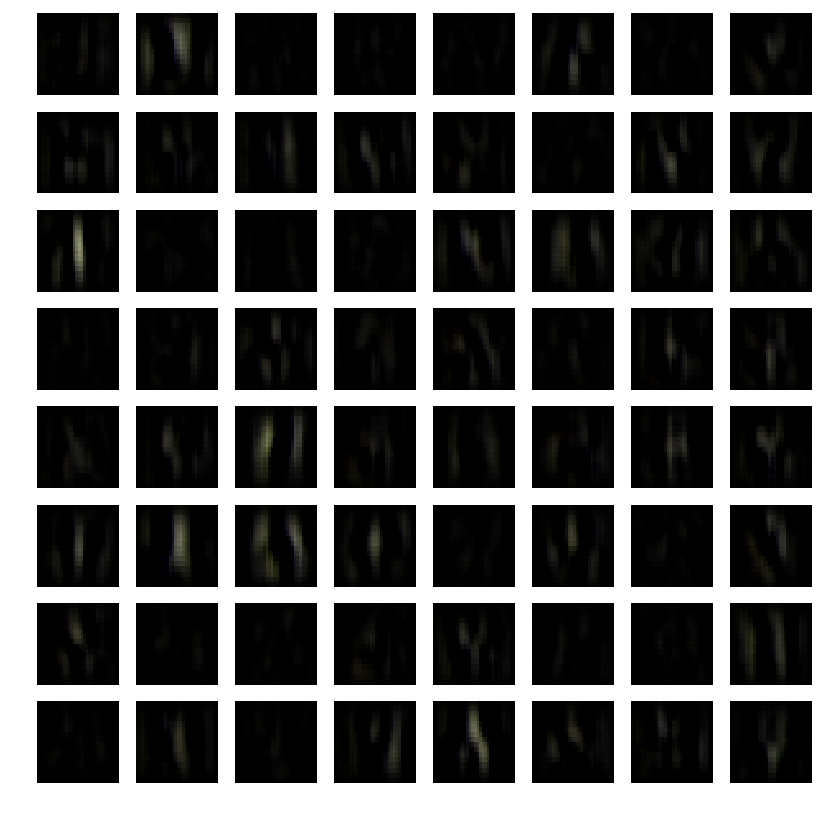

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Filters - JNN


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 640x480 with 0 Axes>

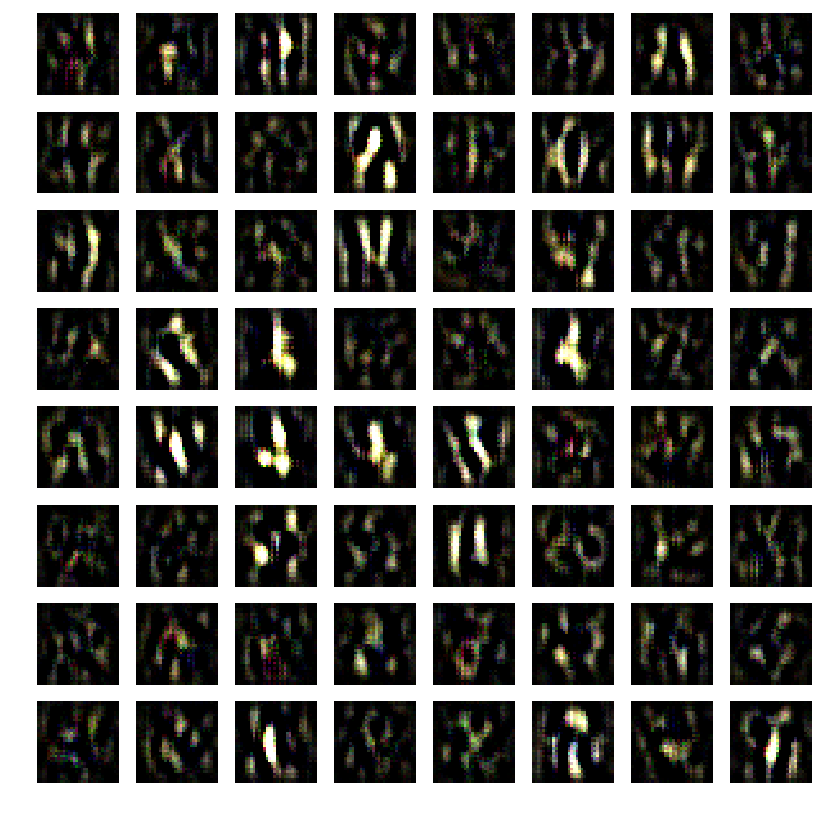

In [50]:
cols = 8
rows = 8
indices = random.sample(range(m3), cols*rows)

dict1 = model_0.W3
atom1_dim = dict1.shape[3]
# print(dict1.shape)

dict2 = F.conv_transpose2d(dict1, model_0.W2, stride=model_0.strd1, dilation=1)
atom2_dim = dict2.shape[3]
# print(dict2.shape)

dict3_0 = F.conv_transpose2d(dict2, model_0.W1, stride=model_0.strd2, dilation=1)
atom3_dim = dict3_0.shape[3]
print(dict3_0.shape)

dict1 = model_jnn.W3
atom1_dim = dict1.shape[3]
# print(dict1.shape)

dict2 = F.conv_transpose2d(dict1, model_jnn.W2, stride=model_jnn.strd1, dilation=1)
atom2_dim = dict2.shape[3]
# print(dict2.shape)

dict3_jnn = F.conv_transpose2d(dict2, model_jnn.W1, stride=model_jnn.strd2, dilation=1)
atom3_dim = dict3_jnn.shape[3]
print(dict3_jnn.shape)


print('Filters - NN')

idx = 1
plt.figure(1)
plt.figure(figsize=(10,10))
for j in range(rows):
    for i in range(cols):
        plt.subplot(cols,rows,idx)
        image = np.swapaxes(dict3_0.cpu().data.numpy()[idx-1]*5, 0, 2)
        image = np.swapaxes(image, 0, 1)
        plt.imshow(image)
        plt.axis('off')
        idx+=1
plt.show()
        
print('Filters - JNN')

idx = 1
plt.figure(2)
plt.figure(figsize=(10,10))
for j in range(rows):
    for i in range(cols):
        plt.subplot(cols,rows,idx)
        image = np.swapaxes(dict3_jnn.cpu().data.numpy()[idx-1]*100, 0, 2)
        image = np.swapaxes(image, 0, 1)
        plt.imshow(image)
        plt.axis('off')
        idx+=1

plt.show()

### Plot histogram activations

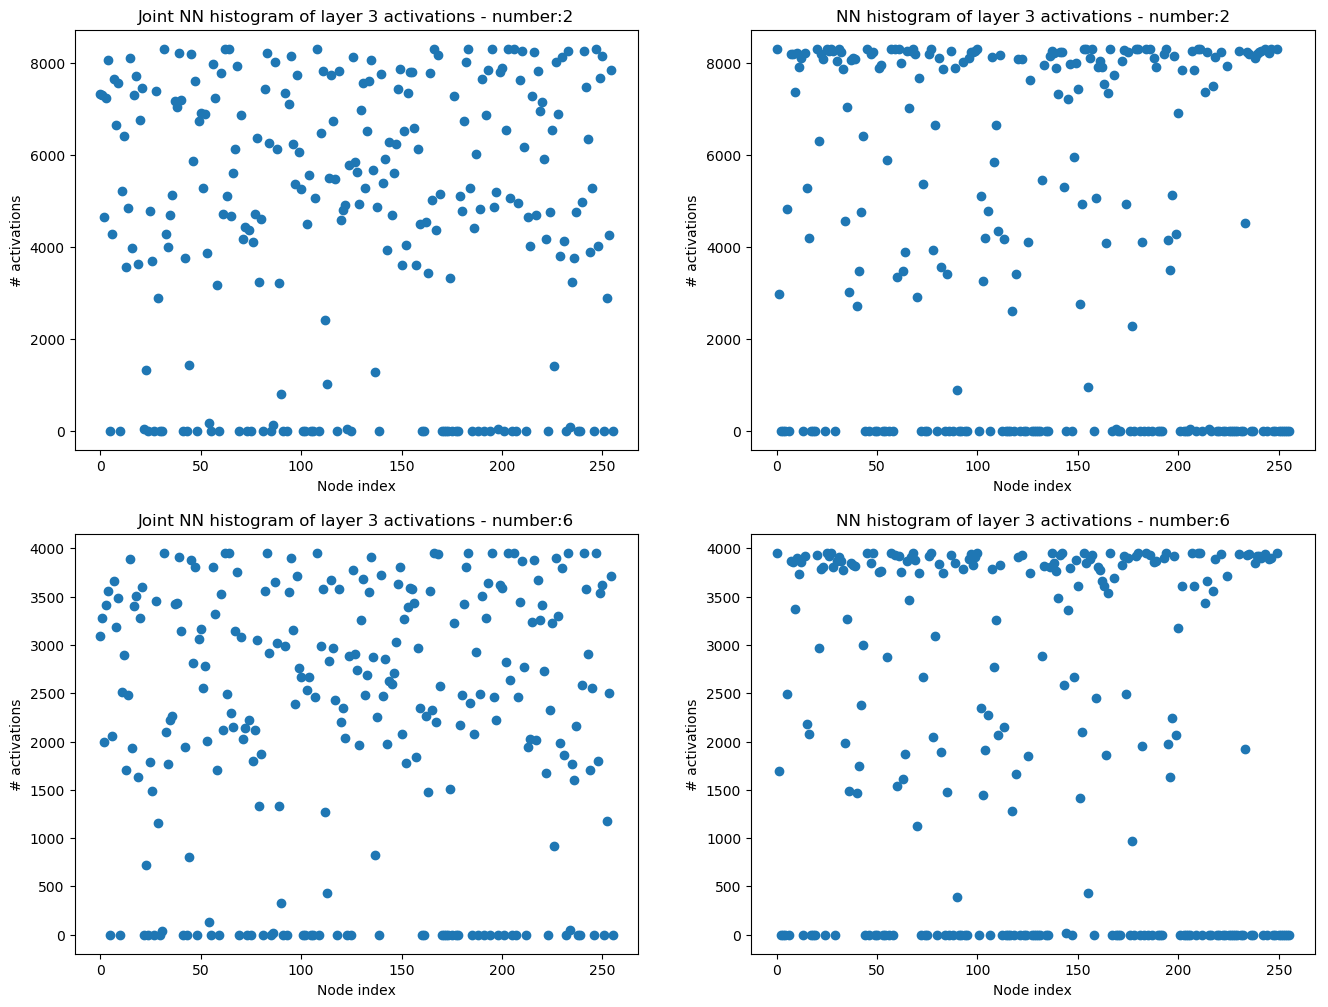

In [51]:
idx1 = 2
idx2 = 6

plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.scatter(np.arange(m3), activations_count3_jnn[idx1,:])
plt.title('Joint NN histogram of layer 3 activations - number:' + str(idx1))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.subplot(2,2,2)
plt.scatter(np.arange(m3), activations_count3_0[idx1,:])
plt.title('NN histogram of layer 3 activations - number:' + str(idx1))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.subplot(2,2,3)
plt.scatter(np.arange(m3), activations_count3_jnn[idx2,:])
plt.title('Joint NN histogram of layer 3 activations - number:' + str(idx2))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.subplot(2,2,4)
plt.scatter(np.arange(m3), activations_count3_0[idx2,:])
plt.title('NN histogram of layer 3 activations - number:' + str(idx2))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.show()


### Compute covariance matrix

Correlation maps between the activation counts across layer 3 for different classes:

Normal neural network:


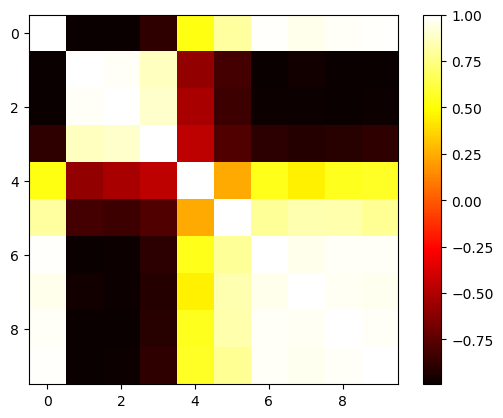

Joint neural network:


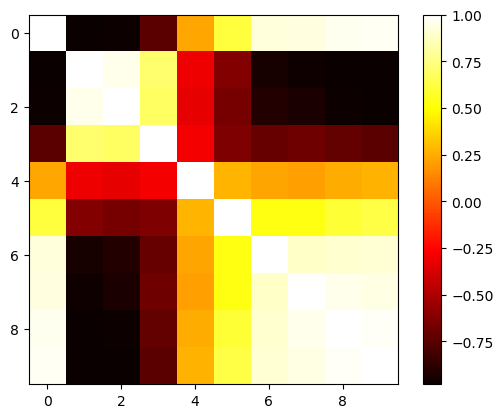

In [43]:
corr_nn = np.corrcoef(activations_count3_0 - np.mean(activations_count3_0, 0))

print('Correlation maps between the activation counts across layer 3 for different classes:')

print('\nNormal neural network:')
plt.figure(1)
plt.imshow(corr_nn, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

print('Joint neural network:')
corr_jnn = np.corrcoef(activations_count3_jnn - np.mean(activations_count3_jnn, 0))
plt.figure(2)
plt.imshow(corr_jnn, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

### Robustness Test

/anaconda/envs/mlvm/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


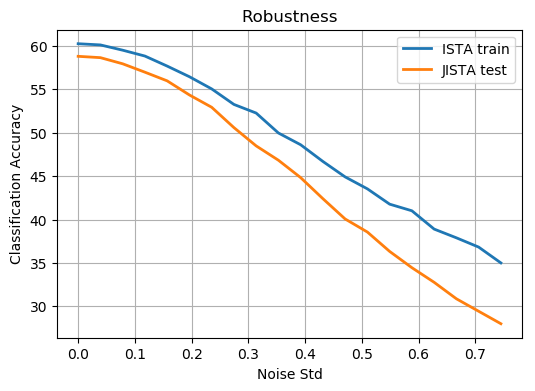

In [22]:
SIGMAS = np.arange(0,200,10)
Acc_0_Robustness = np.zeros((len(SIGMAS),1))
Acc_JS_Robustness = np.zeros((len(SIGMAS),1))

for s in range(len(SIGMAS)):
    
    model_0.eval()
    model_jnn.eval()
    correct_0 = 0
    correct_jnn = 0
    
    for step, (x, y) in enumerate(test_loader):
        x = x + SIGMAS[s]/255 * torch.randn(x.shape)
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        # baseline
        gamma, scores,_,_,_ = model_0(b_x)
        pred = scores.data.max(1, keepdim=True)[1]
        correct_0 += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
        # Joint Sparse
        gamma, scores,_,_,_ = model_jnn.forward(b_x)
        pred = scores.data.max(1, keepdim=True)[1]
        correct_jnn += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()

    Acc_0_Robustness[s] =  100 * float(correct_0) /float(len(test_loader.dataset))
    Acc_JS_Robustness[s] =  100 * float(correct_jnn) /float(len(test_loader.dataset))
    

# Plots
plt.style.use('default')
fig = plt.figure(figsize=(6,4))
plt.plot(SIGMAS/255, Acc_0_Robustness, linewidth = 2,label='ISTA train')
plt.plot(SIGMAS/255, Acc_JS_Robustness, linewidth = 2,label='JISTA test')
plt.grid('on')
plt.title('Robustness')
plt.xlabel('Noise Std')
plt.ylabel('Classification Accuracy')
plt.legend()
plt.show()